In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Mounted at /gdrive
/gdrive/My Drive/ANDL/Homework_1


In [2]:
#!unzip atMost700.zip

In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
# Dataset folders 
dataset_dir = 'atMost700'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

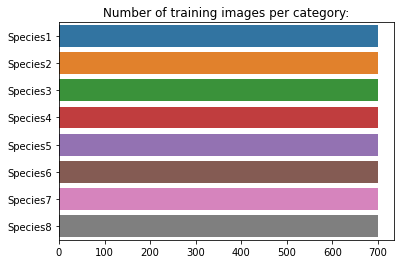

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(
                                        height_shift_range=48,
                                        width_shift_range=48,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [8]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 5600 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [9]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 0. 0. 0. 0. 1. 0.]
Label: 6
Class name: Species7


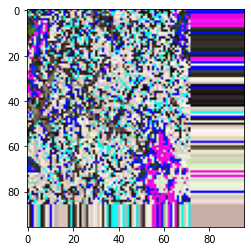

In [10]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [11]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

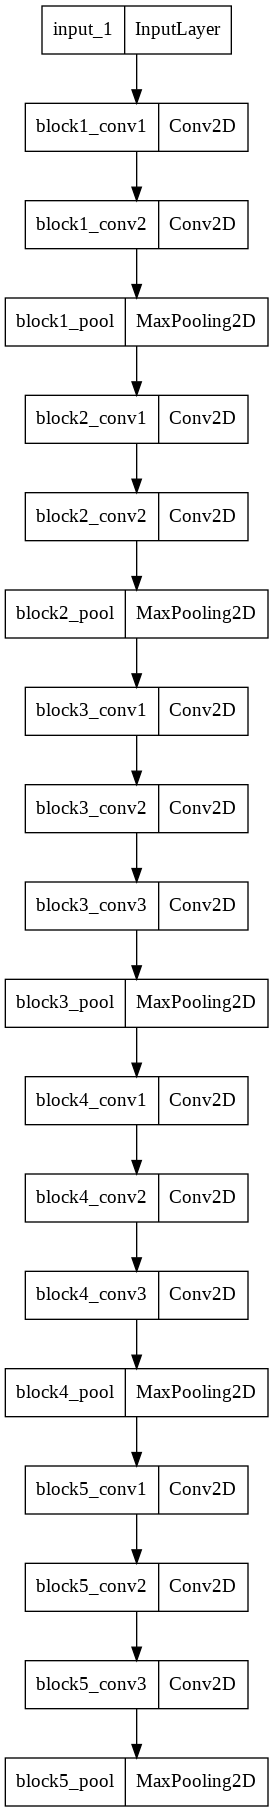

In [12]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [13]:
input_shape = (96, 96, 3)
epochs = 200

In [14]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [15]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [16]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
175/175 [==============================] - ETA: 0s - loss: 4.9503 - accuracy: 0.2405 - precision: 0.2931 - recall: 0.1318 

175/175 [==============================] - 2852s 16s/step - loss: 4.9503 - accuracy: 0.2405 - precision: 0.2931 - recall: 0.1318 - val_loss: 1.5741 - val_accuracy: 0.4023 - val_precision: 0.5648 - val_recall: 0.2068
Epoch 2/200
175/175 [==============================] - ETA: 0s - loss: 1.8528 - accuracy: 0.2862 - precision: 0.4915 - recall: 0.0932

175/175 [==============================] - 28s 163ms/step - loss: 1.8528 - accuracy: 0.2862 - precision: 0.4915 - recall: 0.0932 - val_loss: 1.4256 - val_accuracy: 0.4364 - val_precision: 0.6036 - val_recall: 0.1935
Epoch 3/200
175/175 [==============================] - ETA: 0s - loss: 1.7125 - accuracy: 0.3336 - precision: 0.5298 - recall: 0.1157

175/175 [==============================] - 28s 162ms/step - loss: 1.7125 - accuracy: 0.3336 - precision: 0.5298 - recall: 0.1157 - val_loss: 1.4861 - val_accuracy: 0.4118 - val_precision: 0.5243 - val_recall: 0.2049
Epoch 4/200
175/175 [==============================] - ETA: 0s - loss: 1.6607 - accuracy: 0.3509 - precision: 0.5508 - recall: 0.1268

175/175 [==============================] - 28s 163ms/step - loss: 1.6607 - accuracy: 0.3509 - precision: 0.5508 - recall: 0.1268 - val_loss: 1.4177 - val_accuracy: 0.4630 - val_precision: 0.5926 - val_recall: 0.2732
Epoch 5/200
175/175 [==============================] - ETA: 0s - loss: 1.6168 - accuracy: 0.3761 - precision: 0.5621 - recall: 0.1471

175/175 [==============================] - 28s 161ms/step - loss: 1.6168 - accuracy: 0.3761 - precision: 0.5621 - recall: 0.1471 - val_loss: 1.4220 - val_accuracy: 0.4288 - val_precision: 0.6351 - val_recall: 0.2676
Epoch 6/200
175/175 [==============================] - ETA: 0s - loss: 1.5875 - accuracy: 0.3759 - precision: 0.5719 - recall: 0.1548

175/175 [==============================] - 29s 164ms/step - loss: 1.5875 - accuracy: 0.3759 - precision: 0.5719 - recall: 0.1548 - val_loss: 1.3563 - val_accuracy: 0.4858 - val_precision: 0.6856 - val_recall: 0.2524
Epoch 7/200
175/175 [==============================] - ETA: 0s - loss: 1.5330 - accuracy: 0.4009 - precision: 0.5977 - recall: 0.1704

175/175 [==============================] - 28s 162ms/step - loss: 1.5330 - accuracy: 0.4009 - precision: 0.5977 - recall: 0.1704 - val_loss: 1.3242 - val_accuracy: 0.4668 - val_precision: 0.6526 - val_recall: 0.2638
Epoch 8/200
175/175 [==============================] - ETA: 0s - loss: 1.5136 - accuracy: 0.3989 - precision: 0.6073 - recall: 0.1809

175/175 [==============================] - 28s 160ms/step - loss: 1.5136 - accuracy: 0.3989 - precision: 0.6073 - recall: 0.1809 - val_loss: 1.2795 - val_accuracy: 0.5085 - val_precision: 0.7177 - val_recall: 0.2846
Epoch 9/200
175/175 [==============================] - ETA: 0s - loss: 1.4896 - accuracy: 0.4150 - precision: 0.6264 - recall: 0.1961

175/175 [==============================] - 28s 162ms/step - loss: 1.4896 - accuracy: 0.4150 - precision: 0.6264 - recall: 0.1961 - val_loss: 1.3185 - val_accuracy: 0.4858 - val_precision: 0.6842 - val_recall: 0.2713
Epoch 10/200
175/175 [==============================] - ETA: 0s - loss: 1.4871 - accuracy: 0.4132 - precision: 0.6055 - recall: 0.1988

175/175 [==============================] - 28s 159ms/step - loss: 1.4871 - accuracy: 0.4132 - precision: 0.6055 - recall: 0.1988 - val_loss: 1.3454 - val_accuracy: 0.4592 - val_precision: 0.6000 - val_recall: 0.2732
Epoch 11/200
175/175 [==============================] - ETA: 0s - loss: 1.4619 - accuracy: 0.4313 - precision: 0.6249 - recall: 0.2073

175/175 [==============================] - 28s 162ms/step - loss: 1.4619 - accuracy: 0.4313 - precision: 0.6249 - recall: 0.2073 - val_loss: 1.2237 - val_accuracy: 0.5427 - val_precision: 0.7432 - val_recall: 0.3131
Epoch 12/200
175/175 [==============================] - ETA: 0s - loss: 1.4335 - accuracy: 0.4418 - precision: 0.6362 - recall: 0.2311

175/175 [==============================] - 28s 161ms/step - loss: 1.4335 - accuracy: 0.4418 - precision: 0.6362 - recall: 0.2311 - val_loss: 1.3392 - val_accuracy: 0.5256 - val_precision: 0.6639 - val_recall: 0.2998
Epoch 13/200
175/175 [==============================] - ETA: 0s - loss: 1.4397 - accuracy: 0.4430 - precision: 0.6449 - recall: 0.2289

175/175 [==============================] - 29s 165ms/step - loss: 1.4397 - accuracy: 0.4430 - precision: 0.6449 - recall: 0.2289 - val_loss: 1.2447 - val_accuracy: 0.5218 - val_precision: 0.7336 - val_recall: 0.2979
Epoch 14/200
175/175 [==============================] - ETA: 0s - loss: 1.4378 - accuracy: 0.4387 - precision: 0.6261 - recall: 0.2243

175/175 [==============================] - 29s 163ms/step - loss: 1.4378 - accuracy: 0.4387 - precision: 0.6261 - recall: 0.2243 - val_loss: 1.2437 - val_accuracy: 0.5009 - val_precision: 0.7074 - val_recall: 0.3074
Epoch 15/200
175/175 [==============================] - ETA: 0s - loss: 1.4189 - accuracy: 0.4461 - precision: 0.6468 - recall: 0.2361

175/175 [==============================] - 29s 163ms/step - loss: 1.4189 - accuracy: 0.4461 - precision: 0.6468 - recall: 0.2361 - val_loss: 1.2126 - val_accuracy: 0.5674 - val_precision: 0.7744 - val_recall: 0.2865
Epoch 16/200
175/175 [==============================] - ETA: 0s - loss: 1.3981 - accuracy: 0.4627 - precision: 0.6579 - recall: 0.2541

175/175 [==============================] - 28s 160ms/step - loss: 1.3981 - accuracy: 0.4627 - precision: 0.6579 - recall: 0.2541 - val_loss: 1.2426 - val_accuracy: 0.5332 - val_precision: 0.7017 - val_recall: 0.3169
Epoch 17/200
175/175 [==============================] - ETA: 0s - loss: 1.4010 - accuracy: 0.4607 - precision: 0.6394 - recall: 0.2441

175/175 [==============================] - 28s 162ms/step - loss: 1.4010 - accuracy: 0.4607 - precision: 0.6394 - recall: 0.2441 - val_loss: 1.2337 - val_accuracy: 0.5275 - val_precision: 0.7137 - val_recall: 0.3359
Epoch 18/200
175/175 [==============================] - ETA: 0s - loss: 1.3871 - accuracy: 0.4634 - precision: 0.6533 - recall: 0.2587

175/175 [==============================] - 28s 161ms/step - loss: 1.3871 - accuracy: 0.4634 - precision: 0.6533 - recall: 0.2587 - val_loss: 1.2351 - val_accuracy: 0.5237 - val_precision: 0.7280 - val_recall: 0.3302
Epoch 19/200
175/175 [==============================] - ETA: 0s - loss: 1.3903 - accuracy: 0.4698 - precision: 0.6605 - recall: 0.2595

175/175 [==============================] - 28s 161ms/step - loss: 1.3903 - accuracy: 0.4698 - precision: 0.6605 - recall: 0.2595 - val_loss: 1.2305 - val_accuracy: 0.5712 - val_precision: 0.7398 - val_recall: 0.3454
Epoch 20/200
175/175 [==============================] - ETA: 0s - loss: 1.3970 - accuracy: 0.4636 - precision: 0.6480 - recall: 0.2568

175/175 [==============================] - 28s 160ms/step - loss: 1.3970 - accuracy: 0.4636 - precision: 0.6480 - recall: 0.2568 - val_loss: 1.2124 - val_accuracy: 0.5313 - val_precision: 0.7412 - val_recall: 0.3207
Epoch 21/200
175/175 [==============================] - ETA: 0s - loss: 1.3676 - accuracy: 0.4777 - precision: 0.6536 - recall: 0.2686

175/175 [==============================] - 28s 161ms/step - loss: 1.3676 - accuracy: 0.4777 - precision: 0.6536 - recall: 0.2686 - val_loss: 1.1717 - val_accuracy: 0.5047 - val_precision: 0.7377 - val_recall: 0.3416
Epoch 22/200
175/175 [==============================] - ETA: 0s - loss: 1.3880 - accuracy: 0.4737 - precision: 0.6692 - recall: 0.2713

175/175 [==============================] - 28s 160ms/step - loss: 1.3880 - accuracy: 0.4737 - precision: 0.6692 - recall: 0.2713 - val_loss: 1.1807 - val_accuracy: 0.5674 - val_precision: 0.7848 - val_recall: 0.3321
Epoch 23/200
175/175 [==============================] - ETA: 0s - loss: 1.3912 - accuracy: 0.4613 - precision: 0.6518 - recall: 0.2580

175/175 [==============================] - 29s 164ms/step - loss: 1.3912 - accuracy: 0.4613 - precision: 0.6518 - recall: 0.2580 - val_loss: 1.3869 - val_accuracy: 0.5218 - val_precision: 0.6546 - val_recall: 0.3093
Epoch 24/200
175/175 [==============================] - ETA: 0s - loss: 1.3856 - accuracy: 0.4798 - precision: 0.6608 - recall: 0.2770

175/175 [==============================] - 28s 161ms/step - loss: 1.3856 - accuracy: 0.4798 - precision: 0.6608 - recall: 0.2770 - val_loss: 1.2089 - val_accuracy: 0.5351 - val_precision: 0.7072 - val_recall: 0.2979
Epoch 25/200
175/175 [==============================] - ETA: 0s - loss: 1.3607 - accuracy: 0.4864 - precision: 0.6746 - recall: 0.2818

175/175 [==============================] - 28s 162ms/step - loss: 1.3607 - accuracy: 0.4864 - precision: 0.6746 - recall: 0.2818 - val_loss: 1.2023 - val_accuracy: 0.5465 - val_precision: 0.7143 - val_recall: 0.3036
Epoch 26/200
175/175 [==============================] - ETA: 0s - loss: 1.3840 - accuracy: 0.4712 - precision: 0.6588 - recall: 0.2689

175/175 [==============================] - 28s 159ms/step - loss: 1.3840 - accuracy: 0.4712 - precision: 0.6588 - recall: 0.2689 - val_loss: 1.5632 - val_accuracy: 0.4592 - val_precision: 0.5392 - val_recall: 0.3397
Epoch 27/200
175/175 [==============================] - ETA: 0s - loss: 1.3690 - accuracy: 0.4816 - precision: 0.6725 - recall: 0.2754

175/175 [==============================] - 28s 160ms/step - loss: 1.3690 - accuracy: 0.4816 - precision: 0.6725 - recall: 0.2754 - val_loss: 1.5546 - val_accuracy: 0.4896 - val_precision: 0.5884 - val_recall: 0.3662
Epoch 28/200
175/175 [==============================] - ETA: 0s - loss: 1.3648 - accuracy: 0.4843 - precision: 0.6731 - recall: 0.2916

175/175 [==============================] - 28s 161ms/step - loss: 1.3648 - accuracy: 0.4843 - precision: 0.6731 - recall: 0.2916 - val_loss: 1.1447 - val_accuracy: 0.5636 - val_precision: 0.7823 - val_recall: 0.3681
Epoch 29/200
175/175 [==============================] - ETA: 0s - loss: 1.3752 - accuracy: 0.4800 - precision: 0.6604 - recall: 0.2827

175/175 [==============================] - 28s 161ms/step - loss: 1.3752 - accuracy: 0.4800 - precision: 0.6604 - recall: 0.2827 - val_loss: 1.2048 - val_accuracy: 0.5427 - val_precision: 0.7137 - val_recall: 0.3169


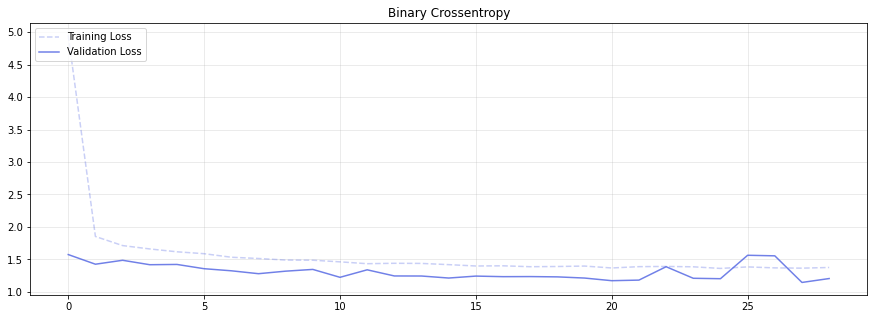

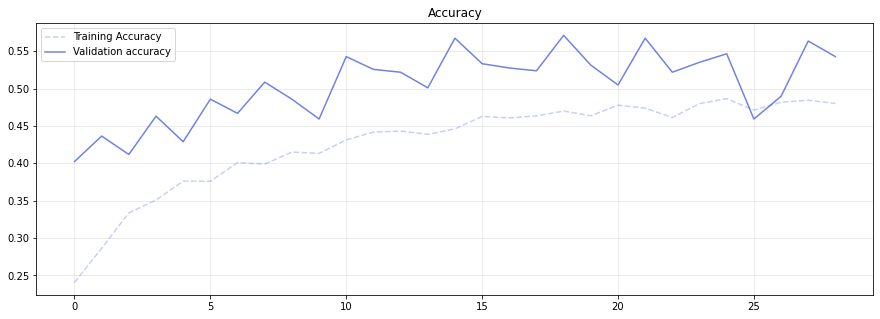

In [17]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [18]:
tl_model.save('Vgg16/FineFineTuning_v1')

In [19]:
tl_model = tfk.models.load_model('Vgg16/FineFineTuning_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [20]:
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [21]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0       

In [22]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [23]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200
175/175 [==============================] - 26s 135ms/step - loss: 1.4679 - accuracy: 0.4279 - precision_1: 0.6051 - recall_1: 0.2230 - val_loss: 1.2604 - val_accuracy: 0.5731 - val_precision_1: 0.7075 - val_recall_1: 0.4497
Epoch 2/200
175/175 [==============================] - 23s 132ms/step - loss: 1.2959 - accuracy: 0.5095 - precision_1: 0.6789 - recall_1: 0.2911 - val_loss: 1.0067 - val_accuracy: 0.6319 - val_precision_1: 0.7993 - val_recall_1: 0.4459
Epoch 3/200
175/175 [==============================] - 23s 131ms/step - loss: 1.2132 - accuracy: 0.5400 - precision_1: 0.7010 - recall_1: 0.3429 - val_loss: 1.0366 - val_accuracy: 0.6072 - val_precision_1: 0.7745 - val_recall_1: 0.4042
Epoch 4/200
175/175 [==============================] - 23s 133ms/step - loss: 1.1513 - accuracy: 0.5746 - precision_1: 0.7259 - recall_1: 0.3879 - val_loss: 1.0600 - val_accuracy: 0.6034 - val_precision_1: 0.7492 - val_recall_1: 0.4307
Epoch 5/200
175/175 [==============================] - 2

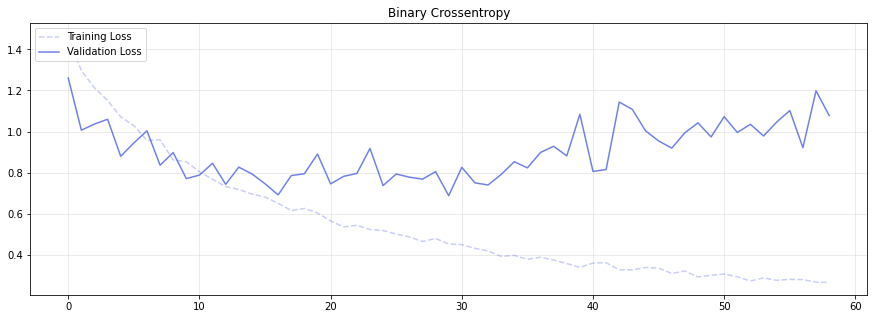

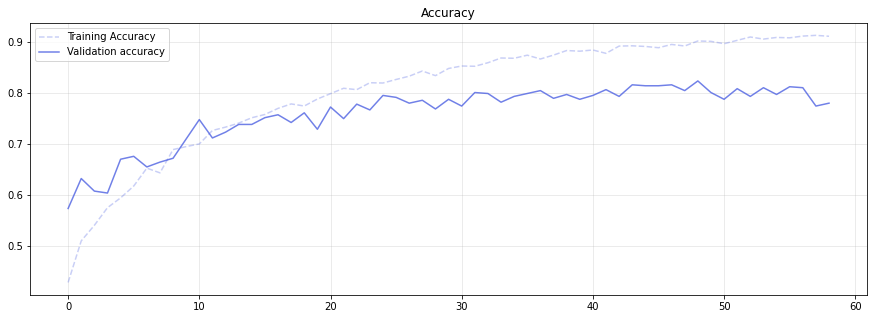

In [24]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [25]:
%cd /gdrive/My Drive/ANDL/Homework_1

/gdrive/My Drive/ANDL/Homework_1


In [26]:
tl_model.save('Vgg16/Tuned_v1_1')

In [27]:
# Test the model
tl_model = tfk.models.load_model("Vgg16/Tuned_v1_1")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 178s 16s/step - loss: 1.3977 - accuracy: 0.8255 - precision_1: 0.8371 - recall_1: 0.8116

Test metrics
{'loss': 1.39773428440094, 'accuracy': 0.8254847526550293, 'precision_1': 0.8371428847312927, 'recall_1': 0.811634361743927}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.8255
Precision: 0.8023
Recall: 0.8055
F1: 0.801


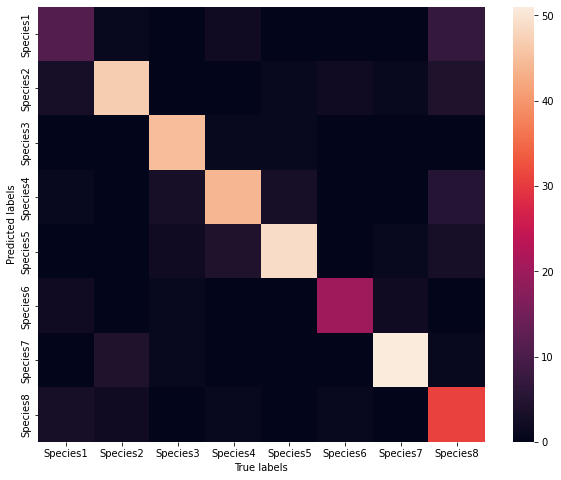

In [28]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()